# VIF Critic Training v2 — Diagnostic-First Notebook

This notebook is a **diagnostic-first** training notebook for the VIF CriticMLP model.
Every section maps to specific GitHub issues and prints results explicitly.

**Issues Surfaced:**
- **#9** — Uncertainty calibration quality
- **#10** — Class imbalance and neutral-dominated predictions
- **#11** — Ordinal structure ignored by MSE loss
- **#12** — Overfitting risk with high parameter-to-sample ratio
- **#14** — Embedding quality and truncation risk

**Scope:** MLP-only (`CriticMLP`). Diagnostic-only embedding probe. Metrics + guidance scorecard.

# Config

In [1]:
CONFIG = {
    # Encoder
    "encoder_model": "all-MiniLM-L6-v2",
    # Loss
    "loss_fn": "mse",  # "mse" or "weighted_mse"
    "weighted_mse_scale": 5.0,  # weight multiplier for non-neutral samples
    # Model
    "hidden_dim": 256,
    "dropout": 0.2,
    # Optimizer
    "learning_rate": 0.001,
    "weight_decay": 0.01,
    # Training
    "batch_size": 16,
    "epochs": 100,
    # Early stopping
    "early_stopping_patience": 20,
    "early_stopping_min_delta": 0.001,
    # LR scheduler
    "scheduler_factor": 0.5,
    "scheduler_patience": 10,
    "scheduler_min_lr": 1e-5,
    # State encoder
    "window_size": 3,
    "ema_alpha": 0.3,
    # MC Dropout
    "mc_dropout_samples": 50,
    # Data splits
    "train_ratio": 0.70,
    "val_ratio": 0.15,
    "seed": 42,
}

print("=" * 50)
print("CONFIGURATION")
print("=" * 50)
for key, value in CONFIG.items():
    print(f"  {key:<30s} {str(value):>15s}")
print("=" * 50)

CONFIGURATION
  encoder_model                  all-MiniLM-L6-v2
  loss_fn                                    mse
  weighted_mse_scale                         5.0
  hidden_dim                                 256
  dropout                                    0.2
  learning_rate                            0.001
  weight_decay                              0.01
  batch_size                                  16
  epochs                                     100
  early_stopping_patience                     20
  early_stopping_min_delta                 0.001
  scheduler_factor                           0.5
  scheduler_patience                          10
  scheduler_min_lr                         1e-05
  window_size                                  3
  ema_alpha                                  0.3
  mc_dropout_samples                          50
  train_ratio                                0.7
  val_ratio                                 0.15
  seed                                        42


# Import Libs

In [ ]:
import os
import sys
from pathlib import Path

notebook_dir = Path.cwd()
if notebook_dir.name == "notebooks":
    os.chdir(notebook_dir.parent)
sys.path.insert(0, ".")

import numpy as np
import polars as pl
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.pairwise import cosine_similarity

from src.vif.dataset import (
    load_all_data,
    split_by_persona,
    merge_labels_and_entries,
    VIFDataset,
)
from src.vif.encoders import SBERTEncoder
from src.vif.state_encoder import StateEncoder
from src.vif.critic import CriticMLP
from src.vif.eval import (
    evaluate_with_uncertainty,
    format_results_table,
    discretize_predictions,
)
from src.models.judge import SCHWARTZ_VALUE_ORDER

# Reproducibility
np.random.seed(CONFIG["seed"])
torch.manual_seed(CONFIG["seed"])

# Device selection
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Working directory: {os.getcwd()}")
print(f"Device: {device}")
print(f"PyTorch: {torch.__version__}")
print(f"Schwartz dimensions: {len(SCHWARTZ_VALUE_ORDER)}")

# Section 1: Data Quality Audit (Issue #10)

**Issue #10 — Class Imbalance:**: Most Schwartz dimensions are neutral-dominated.
The model may learn to predict `0` for everything and still achieve high accuracy.
This section quantifies the imbalance and flags dimensions that may be unlearnable.

In [ ]:
# Cell 1a — Load data and print shapes
labels_df, entries_df = load_all_data()
merged_df = merge_labels_and_entries(labels_df, entries_df)

print(f"Labels shape:  {labels_df.shape}")
print(f"Entries shape: {entries_df.shape}")
print(f"Merged shape:  {merged_df.shape}")
print(f"Unique personas: {merged_df.select('persona_id').n_unique()}")

dropped_label_rows = labels_df.height - merged_df.height
if dropped_label_rows > 0:
    print(f"Dropped label rows after merge: {dropped_label_rows}")
    key_options = [
        ["persona_id", "t_index"],
        ["entry_id"],
    ]
    for keys in key_options:
        if all(k in labels_df.columns for k in keys) and all(
            k in merged_df.columns for k in keys
        ):
            labels_keys = labels_df.select(keys).unique()
            merged_keys = merged_df.select(keys).unique()
            dropped_keys = labels_keys.join(merged_keys, on=keys, how="anti")
            print(f"  Missing key rows by {keys}: {dropped_keys.height}")
            if dropped_keys.height > 0:
                print(dropped_keys.head(5))
            break

print(
    f"\nLabel columns: {[c for c in labels_df.columns if c.startswith('alignment_')]}"
)
print(
    f"Entry text columns: {[c for c in entries_df.columns if c not in labels_df.columns]}"
)


Labels shape:  (740, 15)
Entries shape: (722, 8)
Merged shape:  (722, 21)
Unique personas: 100
Dropped label rows after merge: 18
  Missing key rows by ['persona_id', 't_index']: 18
shape: (5, 2)
┌────────────┬─────────┐
│ persona_id ┆ t_index │
│ ---        ┆ ---     │
│ str        ┆ i64     │
╞════════════╪═════════╡
│ 4d5fbf22   ┆ 7       │
│ 4d5fbf22   ┆ 11      │
│ 4d5fbf22   ┆ 8       │
│ 437659f3   ┆ 3       │
│ 437659f3   ┆ 4       │
└────────────┴─────────┘

Label columns: ['alignment_vector', 'alignment_self_direction', 'alignment_stimulation', 'alignment_hedonism', 'alignment_achievement', 'alignment_power', 'alignment_security', 'alignment_conformity', 'alignment_tradition', 'alignment_benevolence', 'alignment_universalism']
Entry text columns: ['persona_name', 'core_values', 'initial_entry', 'nudge_text', 'response_text']


Dimension                -1      0     +1    Ratio     Flag
-------------------------------------------------------
self_direction          119    328    275      2.8         
stimulation              44    582     96     13.2     >10x
hedonism                 89    521    112      5.9         
achievement              58    453    211      7.8         
power                    65    588     69      9.0         
security                103    487    132      4.7         
conformity               96    470    156      4.9         
tradition                50    520    152     10.4     >10x
benevolence              83    350    289      4.2         
universalism              5    644     73    128.8     >10x

Overall neutral %: 68.5%


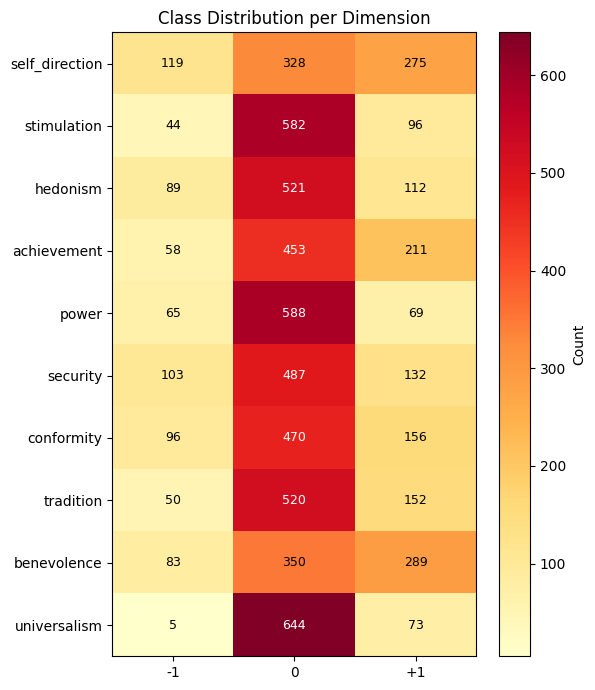

In [4]:
# Cell 1b — Class distribution per dimension
n_dims = len(SCHWARTZ_VALUE_ORDER)
distribution = np.zeros((n_dims, 3), dtype=int)  # rows=dims, cols=[-1, 0, +1]
class_labels = [-1, 0, 1]

for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    col = f"alignment_{dim}"
    series = merged_df.select(col).to_series()
    for j, val in enumerate(class_labels):
        distribution[i, j] = int((series == val).sum())

# Compute imbalance ratios
imbalance_ratios = []
for i in range(n_dims):
    row = distribution[i]
    ratio = float("inf") if (row == 0).any() else row.max() / row.min()
    imbalance_ratios.append(ratio)

# Print table
print(f"{'Dimension':<20s} {'-1':>6s} {'0':>6s} {'+1':>6s} {'Ratio':>8s} {'Flag':>8s}")
print("-" * 55)
for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    flag = ">10x" if imbalance_ratios[i] > 10 else ""
    print(
        f"{dim:<20s} {distribution[i, 0]:>6d} {distribution[i, 1]:>6d} {distribution[i, 2]:>6d} {imbalance_ratios[i]:>8.1f} {flag:>8s}"
    )

neutral_pct = distribution[:, 1].sum() / distribution.sum() * 100
print(f"\nOverall neutral %: {neutral_pct:.1f}%")

# Heatmap
fig, ax = plt.subplots(figsize=(6, 7))
im = ax.imshow(distribution, cmap="YlOrRd", aspect="auto")
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(["-1", "0", "+1"])
ax.set_yticks(range(n_dims))
ax.set_yticklabels(SCHWARTZ_VALUE_ORDER)
ax.set_title("Class Distribution per Dimension")
for i in range(n_dims):
    for j in range(3):
        color = "white" if distribution[i, j] > distribution.max() * 0.6 else "black"
        ax.text(
            j,
            i,
            str(distribution[i, j]),
            ha="center",
            va="center",
            fontsize=9,
            color=color,
        )
plt.colorbar(im, ax=ax, label="Count")
plt.tight_layout()
plt.show()


In [5]:
# Cell 1c — Sparsity flags: dimensions where any class < 10 samples
MIN_SAMPLES = 10

print(f"{'Dimension':<20s} {'Min class':>10s} {'Min count':>10s} {'Status':>12s}")
print("-" * 55)
unlearnable = []
for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    min_idx = distribution[i].argmin()
    min_count = distribution[i, min_idx]
    min_class = class_labels[min_idx]
    status = "UNLEARNABLE" if min_count < MIN_SAMPLES else "OK"
    if min_count < MIN_SAMPLES:
        unlearnable.append(dim)
    print(f"{dim:<20s} {min_class:>10d} {min_count:>10d} {status:>12s}")

print(
    f"\nUnlearnable dims (any class < {MIN_SAMPLES} samples): {unlearnable if unlearnable else 'None'}"
)

Dimension             Min class  Min count       Status
-------------------------------------------------------
self_direction               -1        119           OK
stimulation                  -1         44           OK
hedonism                     -1         89           OK
achievement                  -1         58           OK
power                        -1         65           OK
security                     -1        103           OK
conformity                   -1         96           OK
tradition                    -1         50           OK
benevolence                  -1         83           OK
universalism                 -1          5  UNLEARNABLE

Unlearnable dims (any class < 10 samples): ['universalism']


# Section 2: Embedding Quality Probe (Issue #14)


**Issue #14 — Embedding Quality:** Are SBERT embeddings discriminative enough for value alignment? Does truncation lose information from long entries?

This section probes the encoder without retraining.

In [6]:
# Cell 2a — Random persona/entry verification
text_encoder = SBERTEncoder(CONFIG["encoder_model"])
state_encoder = StateEncoder(
    text_encoder,
    window_size=CONFIG["window_size"],
    ema_alpha=CONFIG["ema_alpha"],
)

print(f"Encoder: {text_encoder.model_name}")
print(f"Embedding dim: {text_encoder.embedding_dim}")
print(f"State dim: {state_encoder.state_dim}")

# Sample one random entry
rng = np.random.default_rng(CONFIG["seed"])
sample_idx = rng.integers(0, len(merged_df))
sample = merged_df.row(sample_idx, named=True)

print(f"\n{'=' * 60}")
print(f"RANDOM ENTRY VERIFICATION (row {sample_idx})")
print(f"{'=' * 60}")
print(f"persona_id:    {sample['persona_id']}")
print(f"persona_name:  {sample.get('persona_name', 'N/A')}")
print(f"core_values:   {sample.get('core_values', 'N/A')}")
print(f"date:          {sample['date']}")
print(f"t_index:       {sample['t_index']}")

print(f"\n--- initial_entry (first 200 chars) ---")
print(f"{(sample['initial_entry'] or '')[:200]}")
print(f"\n--- nudge_text (first 200 chars) ---")
print(f"{(sample['nudge_text'] or '')[:200]}")
print(f"\n--- response_text (first 200 chars) ---")
print(f"{(sample['response_text'] or '')[:200]}")

# Concatenated text
full_text = state_encoder.concatenate_entry_text(
    sample["initial_entry"], sample["nudge_text"], sample["response_text"]
)
print(f"\n--- concatenated text length: {len(full_text)} chars ---")

# Alignment vector
alignment = sample["alignment_vector"]
print(f"\nAlignment vector:")
for dim, val in zip(SCHWARTZ_VALUE_ORDER, alignment):
    marker = "  " if val == 0 else " *"
    print(f"  {dim:<20s} {val:+d}{marker}")

# Embedding
embedding = text_encoder.encode([full_text])[0]
print(f"\nEmbedding shape: {embedding.shape}")
print(f"First 10 values: {embedding[:10]}")
print(f"L2 norm: {np.linalg.norm(embedding):.4f}")

/Users/desmondchoy/Projects/twinkl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Encoder: all-MiniLM-L6-v2
Embedding dim: 384
State dim: 1174

RANDOM ENTRY VERIFICATION (row 64)
persona_id:    1b8b7276
persona_name:  Nabil Khoury
core_values:   ['Security', 'Conformity']
date:          2025-07-09
t_index:       1

--- initial_entry (first 200 chars) ---
Got pulled into a meeting about "organizational restructuring." They didn't say layoffs but the room felt like a dentist's waiting area. My manager kept using phrases like "right-sizing" and "strategi

--- nudge_text (first 200 chars) ---
You mentioned asking no questions. What would you have asked?

--- response_text (first 200 chars) ---
Whether my department is on the list. Whether seventeen years counts for anything. But you don't ask those things in front of everyone. You wait, you read the room, you figure it out without making yo

--- concatenated text length: 897 chars ---

Alignment vector:
  self_direction       -1 *
  stimulation          +0  
  hedonism             +0  
  achievement          +0  
  powe

In [7]:
# Cell 2b — Sentiment polarity test
opposite_pairs = [
    (
        "I helped my neighbor move their furniture today",
        "I refused to help my neighbor when they asked",
    ),
    (
        "I followed the company guidelines carefully",
        "I deliberately broke the rules at work",
    ),
    (
        "I explored a new creative hobby today",
        "I stuck to my rigid routine and avoided anything new",
    ),
    (
        "I saved money for my emergency fund",
        "I spent recklessly without thinking about the future",
    ),
    (
        "I volunteered at the community center",
        "I ignored the community volunteer request",
    ),
    (
        "I pursued my own passion project today",
        "I gave up my personal goals to please others",
    ),
]
equivalent_pairs = [
    (
        "I helped my friend with their problem",
        "I assisted my colleague with their challenge",
    ),
    ("I feel happy and content today", "I am joyful and satisfied right now"),
]

print(f"{'Type':<12s} {'Cosine':>8s}  Pair (truncated)")
print("-" * 80)

opposite_sims = []
for s1, s2 in opposite_pairs:
    emb = text_encoder.encode([s1, s2])
    sim = cosine_similarity(emb[[0]], emb[[1]])[0, 0]
    opposite_sims.append(sim)
    print(f"{'Opposite':<12s} {sim:>8.3f}  {s1[:30]}... vs {s2[:30]}...")

equiv_sims = []
for s1, s2 in equivalent_pairs:
    emb = text_encoder.encode([s1, s2])
    sim = cosine_similarity(emb[[0]], emb[[1]])[0, 0]
    equiv_sims.append(sim)
    print(f"{'Equivalent':<12s} {sim:>8.3f}  {s1[:30]}... vs {s2[:30]}...")

discrimination_gap = np.mean(equiv_sims) - np.mean(opposite_sims)
print(f"\nMean opposite sim:   {np.mean(opposite_sims):.3f}")
print(f"Mean equivalent sim: {np.mean(equiv_sims):.3f}")
print(f"Discrimination gap:  {discrimination_gap:.3f}  (higher = better)")

Type           Cosine  Pair (truncated)
--------------------------------------------------------------------------------
Opposite        0.610  I helped my neighbor move thei... vs I refused to help my neighbor ...
Opposite        0.464  I followed the company guideli... vs I deliberately broke the rules...
Opposite        0.335  I explored a new creative hobb... vs I stuck to my rigid routine an...
Opposite        0.411  I saved money for my emergency... vs I spent recklessly without thi...
Opposite        0.595  I volunteered at the community... vs I ignored the community volunt...
Opposite        0.453  I pursued my own passion proje... vs I gave up my personal goals to...
Equivalent      0.526  I helped my friend with their ... vs I assisted my colleague with t...
Equivalent      0.664  I feel happy and content today... vs I am joyful and satisfied righ...

Mean opposite sim:   0.478
Mean equivalent sim: 0.595
Discrimination gap:  0.117  (higher = better)


Token indices sequence length is longer than the specified maximum sequence length for this model (344 > 256). Running this sequence through the model will result in indexing errors


Max context length: 256 tokens

Token count statistics:
  Min:    18
  Mean:   207.0
  Median: 193.5
  P90:    365
  P95:    408
  Max:    709

Truncated entries: 240/722 (33.2%)


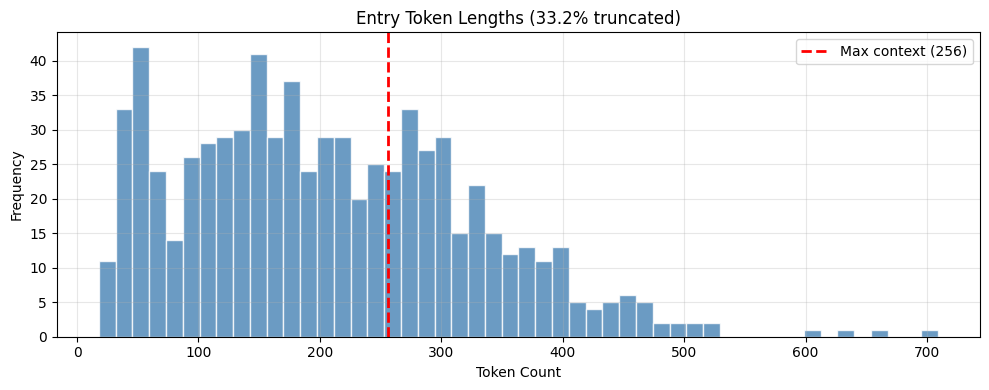

In [8]:
# Cell 2c — Entry length / truncation risk
tokenizer = text_encoder._model.tokenizer
max_seq_length = text_encoder._model.max_seq_length

all_texts = []
for row in merged_df.iter_rows(named=True):
    text = state_encoder.concatenate_entry_text(
        row["initial_entry"], row["nudge_text"], row["response_text"]
    )
    all_texts.append(text)

token_counts = []
for text in all_texts:
    tokens = tokenizer.encode(text, add_special_tokens=True)
    token_counts.append(len(tokens))

token_counts = np.array(token_counts)
n_truncated = (token_counts > max_seq_length).sum()
pct_truncated = n_truncated / len(token_counts) * 100

print(f"Max context length: {max_seq_length} tokens")
print(f"\nToken count statistics:")
print(f"  Min:    {token_counts.min()}")
print(f"  Mean:   {token_counts.mean():.1f}")
print(f"  Median: {np.median(token_counts):.1f}")
print(f"  P90:    {np.percentile(token_counts, 90):.0f}")
print(f"  P95:    {np.percentile(token_counts, 95):.0f}")
print(f"  Max:    {token_counts.max()}")
print(f"\nTruncated entries: {n_truncated}/{len(token_counts)} ({pct_truncated:.1f}%)")

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(token_counts, bins=50, color="steelblue", edgecolor="white", alpha=0.8)
ax.axvline(
    max_seq_length,
    color="red",
    linestyle="--",
    linewidth=2,
    label=f"Max context ({max_seq_length})",
)
ax.set_xlabel("Token Count")
ax.set_ylabel("Frequency")
ax.set_title(f"Entry Token Lengths ({pct_truncated:.1f}% truncated)")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Section 3: Model & Training (Issue #12)


**Issue #12 — Overfitting Risk:** With ~500 training samples and ~370K parameters, the model has a very high parameter-to-sample ratio. This section quantifies the risk and monitors the training/validation gap.

In [9]:
# Cell 3a — Create model
model = CriticMLP(
    input_dim=state_encoder.state_dim,
    hidden_dim=CONFIG["hidden_dim"],
    dropout=CONFIG["dropout"],
)
model.to(device)

n_params = sum(p.numel() for p in model.parameters())
print(f"Architecture:\n{model}\n")
print(f"Total parameters: {n_params:,}")

Architecture:
CriticMLP(
  (fc1): Linear(in_features=1174, out_features=256, bias=True)
  (ln1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (ln2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc_out): Linear(in_features=256, out_features=10, bias=True)
  (gelu): GELU(approximate='none')
  (tanh): Tanh()
)

Total parameters: 370,186


In [10]:
# Cell 3b — Create datasets and dataloaders
print("Creating datasets (caching embeddings)...")
train_df, val_df, test_df = split_by_persona(
    labels_df,
    entries_df,
    train_ratio=CONFIG["train_ratio"],
    val_ratio=CONFIG["val_ratio"],
    seed=CONFIG["seed"],
)

train_dataset = VIFDataset(train_df, state_encoder, cache_embeddings=True)
val_dataset = VIFDataset(val_df, state_encoder, cache_embeddings=True)
test_dataset = VIFDataset(test_df, state_encoder, cache_embeddings=True)

train_loader = DataLoader(train_dataset, batch_size=CONFIG["batch_size"], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=CONFIG["batch_size"], shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=CONFIG["batch_size"], shuffle=False)

n_train = len(train_dataset)
n_val = len(val_dataset)
n_test = len(test_dataset)

print(f"\nSplit sizes:")
print(
    f"  Train: {n_train} samples ({train_df.select('persona_id').n_unique()} personas) -> {len(train_loader)} batches"
)
print(
    f"  Val:   {n_val} samples ({val_df.select('persona_id').n_unique()} personas) -> {len(val_loader)} batches"
)
print(
    f"  Test:  {n_test} samples ({test_df.select('persona_id').n_unique()} personas) -> {len(test_loader)} batches"
)

Creating datasets (caching embeddings)...


Batches: 100%|██████████| 4/4 [00:00<00:00, 17.31it/s]


Split sizes:
  Train: 506 samples (70 personas) -> 32 batches
  Val:   106 samples (14 personas) -> 7 batches
  Test:  110 samples (16 personas) -> 7 batches


In [11]:
# Cell 3c — Overfitting risk check
param_sample_ratio = n_params / n_train
print(f"Parameters:       {n_params:,}")
print(f"Training samples: {n_train}")
print(f"Param/sample ratio: {param_sample_ratio:.1f}x")
print()
if param_sample_ratio > 100:
    print("SEVERE overfitting risk (>100x). Model will likely memorize training data.")
elif param_sample_ratio > 10:
    print("HIGH overfitting risk (>10x). Strong regularization essential.")
elif param_sample_ratio > 1:
    print("MODERATE overfitting risk (>1x). Monitor train/val gap carefully.")
else:
    print("Low overfitting risk (<1x).")

Parameters:       370,186
Training samples: 506
Param/sample ratio: 731.6x

SEVERE overfitting risk (>100x). Model will likely memorize training data.


In [12]:
# Cell 3d — Training loop


class WeightedMSELoss(nn.Module):
    """MSE loss that upweights non-neutral targets."""

    def __init__(self, neutral_weight=1.0, non_neutral_weight=5.0):
        super().__init__()
        self.neutral_weight = neutral_weight
        self.non_neutral_weight = non_neutral_weight

    def forward(self, predictions, targets):
        weights = torch.where(
            targets.abs() < 0.5,
            self.neutral_weight,
            self.non_neutral_weight,
        )
        return (weights * (predictions - targets) ** 2).mean()


# Select loss function
if CONFIG["loss_fn"] == "weighted_mse":
    train_criterion = WeightedMSELoss(
        neutral_weight=1.0,
        non_neutral_weight=CONFIG["weighted_mse_scale"],
    )
    print(
        f"Training loss: Weighted MSE (non-neutral scale={CONFIG['weighted_mse_scale']})"
    )
else:
    train_criterion = nn.MSELoss()
    print(f"Training loss: MSE")

val_criterion = nn.MSELoss()  # always unweighted for comparability
print(f"Validation loss: MSE (unweighted)")

# Optimizer and scheduler
optimizer = AdamW(
    model.parameters(), lr=CONFIG["learning_rate"], weight_decay=CONFIG["weight_decay"]
)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=CONFIG["scheduler_factor"],
    patience=CONFIG["scheduler_patience"],
    min_lr=CONFIG["scheduler_min_lr"],
)

# Training loop
history = {"train_loss": [], "val_loss": [], "lr": []}
best_val_loss = float("inf")
best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
best_epoch = 0
patience_counter = 0
completed_epochs = 0

print(f"\nTraining for up to {CONFIG['epochs']} epochs...")
print("-" * 70)

for epoch in range(CONFIG["epochs"]):
    # Train
    model.train()
    train_loss = 0.0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        pred = model(batch_x)
        loss = train_criterion(pred, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)

    # Validate (always unweighted MSE)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            pred = model(batch_x)
            val_loss += val_criterion(pred, batch_y).item()
    val_loss /= len(val_loader)

    # Guard against non-finite val_loss
    if not np.isfinite(val_loss):
        print(f"Epoch {epoch + 1:3d}: non-finite val_loss={val_loss}, stopping")
        break

    scheduler.step(val_loss)
    current_lr = optimizer.param_groups[0]["lr"]

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["lr"].append(current_lr)
    completed_epochs = len(history["val_loss"])

    if val_loss < best_val_loss - CONFIG["early_stopping_min_delta"]:
        best_val_loss = val_loss
        best_epoch = epoch
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        patience_counter = 0
        print(
            f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f} [BEST]"
        )
    else:
        patience_counter += 1
        if (epoch + 1) % 10 == 0:
            print(
                f"Epoch {epoch + 1:3d}: train={train_loss:.4f}, val={val_loss:.4f}, lr={current_lr:.6f}"
            )

    if patience_counter >= CONFIG["early_stopping_patience"]:
        print(f"\nEarly stopping at epoch {epoch + 1}")
        break

if completed_epochs == 0:
    print("\nNo valid epochs completed; skipping downstream diagnostics.")
else:
    print(f"\nBest validation loss: {best_val_loss:.4f} at epoch {best_epoch + 1}")


Training loss: MSE
Validation loss: MSE (unweighted)

Training for up to 100 epochs...
----------------------------------------------------------------------
Epoch   1: train=0.3175, val=0.2586, lr=0.001000 [BEST]
Epoch   2: train=0.2216, val=0.2529, lr=0.001000 [BEST]
Epoch  10: train=0.0528, val=0.2750, lr=0.001000
Epoch  20: train=0.0283, val=0.2822, lr=0.000500

Early stopping at epoch 22

Best validation loss: 0.2529 at epoch 2


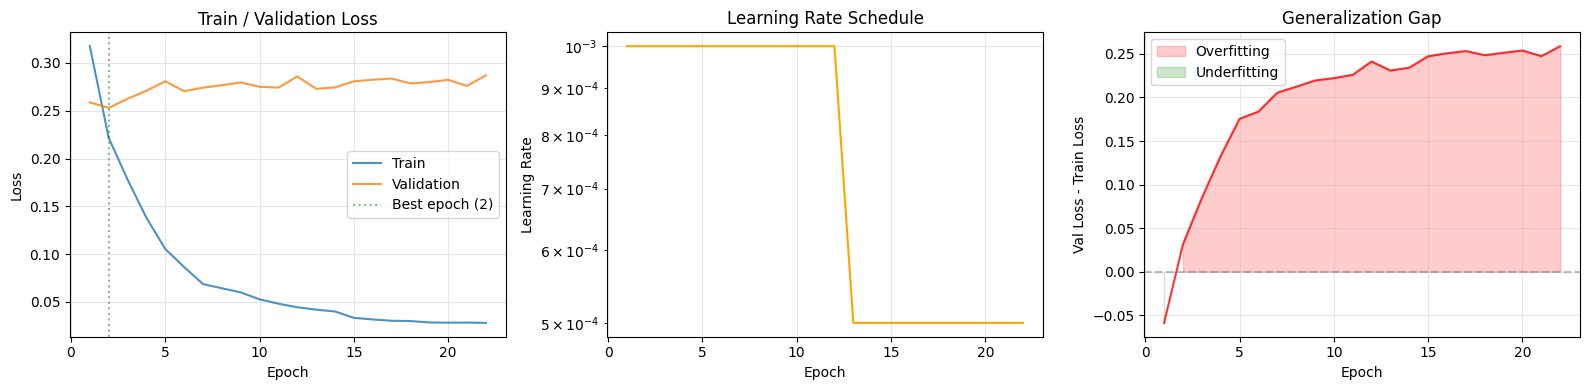

Gap at best epoch (2): +0.0314
Final gap: +0.2589
Moderate overfitting detected


In [13]:
# Cell 3e — Training curves
if len(history["train_loss"]) == 0:
    gap_at_best = float("nan")
    final_gap = float("nan")
    print("No valid training history to plot. Check training loop logs above.")
else:
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    epochs_range = range(1, len(history["train_loss"]) + 1)

    # Panel 1: Train/val loss
    axes[0].plot(epochs_range, history["train_loss"], label="Train", alpha=0.8)
    axes[0].plot(epochs_range, history["val_loss"], label="Validation", alpha=0.8)
    axes[0].axvline(
        best_epoch + 1,
        color="green",
        linestyle=":",
        alpha=0.5,
        label=f"Best epoch ({best_epoch + 1})",
    )
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].set_title("Train / Validation Loss")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Panel 2: LR schedule
    axes[1].plot(epochs_range, history["lr"], color="orange")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Learning Rate")
    axes[1].set_title("Learning Rate Schedule")
    axes[1].set_yscale("log")
    axes[1].grid(True, alpha=0.3)

    # Panel 3: Generalization gap
    gen_gap = np.array(history["val_loss"]) - np.array(history["train_loss"])
    axes[2].plot(epochs_range, gen_gap, color="red", alpha=0.8)
    axes[2].axhline(0, color="gray", linestyle="--", alpha=0.5)
    axes[2].fill_between(
        epochs_range,
        0,
        gen_gap,
        where=gen_gap > 0,
        alpha=0.2,
        color="red",
        label="Overfitting",
    )
    axes[2].fill_between(
        epochs_range,
        0,
        gen_gap,
        where=gen_gap <= 0,
        alpha=0.2,
        color="green",
        label="Underfitting",
    )
    axes[2].set_xlabel("Epoch")
    axes[2].set_ylabel("Val Loss - Train Loss")
    axes[2].set_title("Generalization Gap")
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Summary
    gap_at_best = history["val_loss"][best_epoch] - history["train_loss"][best_epoch]
    final_gap = history["val_loss"][-1] - history["train_loss"][-1]
    print(f"Gap at best epoch ({best_epoch + 1}): {gap_at_best:+.4f}")
    print(f"Final gap: {final_gap:+.4f}")
    if gap_at_best > 0.05:
        print("Significant overfitting detected")
    elif gap_at_best > 0.02:
        print("Moderate overfitting detected")
    else:
        print("Generalization gap is small")


# Section 4: Evaluation Dashboard (Issues #10, #11)


**Issue #10 — Class Imbalance:** Does the model predict only neutrals?

**Issue #11 — Ordinal Structure:** Is MSE causing the model to hedge toward 0?

This section provides confusion matrices and prediction distributions to diagnose both.

In [14]:
# Cell 4a — Load best model and run full evaluation
model.load_state_dict(best_model_state)
model.to(device)

print("Evaluating with MC Dropout uncertainty...")
results = evaluate_with_uncertainty(
    model,
    test_loader,
    n_mc_samples=CONFIG["mc_dropout_samples"],
    device=device,
    include_ordinal_metrics=True,
)

# Extract arrays for use in later cells
predictions = results["predictions"]
targets = results["targets"]
uncertainties = results["uncertainties"]

print(f"\n{format_results_table(results)}")

mse_per_dim = results["mse_per_dim"]
print(f"\nMSE per dimension:")
for dim in SCHWARTZ_VALUE_ORDER:
    print(f"  {dim:<20s} {mse_per_dim[dim]:.4f}")
print(f"  {'MEAN':<20s} {results['mse_mean']:.4f}")


Evaluating with MC Dropout uncertainty...

Dimension                   MAE   Spearman   Accuracy        QWK
----------------------------------------------------------------
self_direction           0.5788      0.445     50.00%      0.234
stimulation              0.2952      0.429     74.55%        N/A
hedonism                 0.2861      0.285     85.45%      0.418
achievement              0.4495      0.519     58.18%      0.155
power                    0.2746      0.492     77.27%        N/A
security                 0.4048      0.267     72.73%      0.343
conformity               0.4647      0.373     56.36%      0.189
tradition                0.3490      0.597     68.18%      0.079
benevolence              0.4929      0.217     56.36%      0.000
universalism             0.1387      0.105     96.36%      0.491
----------------------------------------------------------------
MEAN                     0.3734      0.373     69.55%      0.239

Calibration:
  Error-uncertainty correlation: 

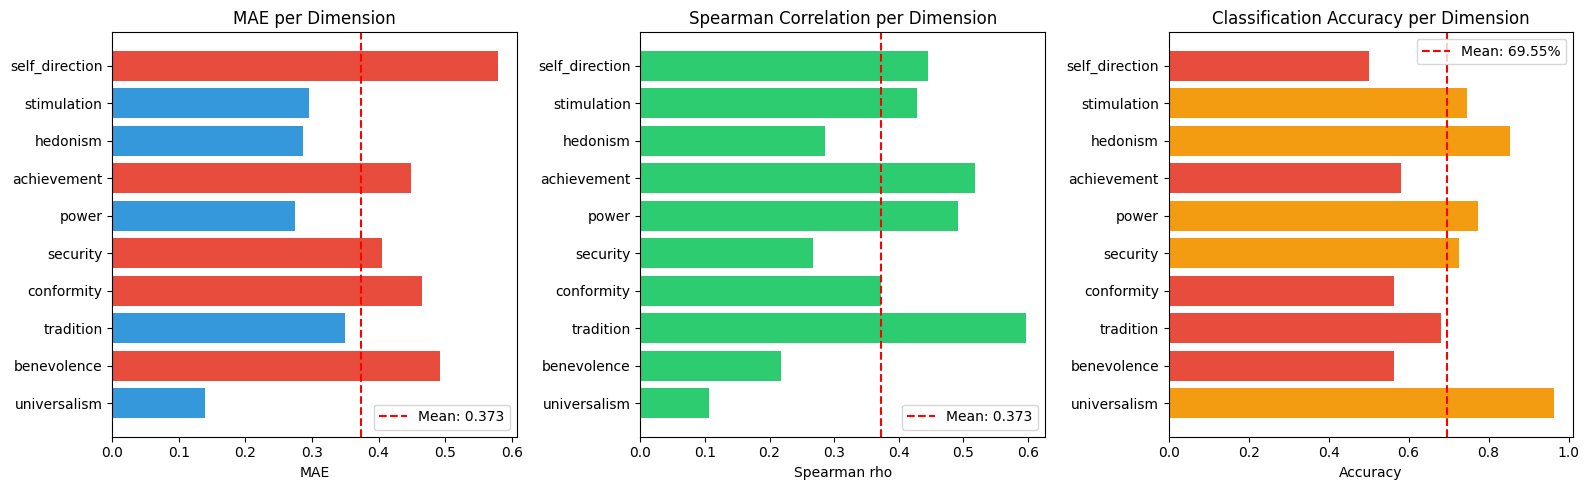

In [15]:
# Cell 4b — Per-dimension bar charts (MAE, Spearman, Accuracy)
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
dims = SCHWARTZ_VALUE_ORDER

# MAE
mae_vals = [results["mae_per_dim"][d] for d in dims]
colors_mae = ["#e74c3c" if v > np.mean(mae_vals) else "#3498db" for v in mae_vals]
axes[0].barh(dims, mae_vals, color=colors_mae)
axes[0].axvline(
    results["mae_mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['mae_mean']:.3f}",
)
axes[0].set_xlabel("MAE")
axes[0].set_title("MAE per Dimension")
axes[0].legend()
axes[0].invert_yaxis()

# Spearman
spearman_vals = [results["spearman_per_dim"][d] for d in dims]
colors_sp = ["#e74c3c" if (np.isnan(v) or v < 0) else "#2ecc71" for v in spearman_vals]
plot_sp = [0 if np.isnan(v) else v for v in spearman_vals]
axes[1].barh(dims, plot_sp, color=colors_sp)
axes[1].axvline(
    results["spearman_mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['spearman_mean']:.3f}",
)
axes[1].set_xlabel("Spearman rho")
axes[1].set_title("Spearman Correlation per Dimension")
axes[1].legend()
axes[1].invert_yaxis()

# Accuracy
acc_vals = [results["accuracy_per_dim"][d] for d in dims]
colors_acc = ["#e74c3c" if v < np.mean(acc_vals) else "#f39c12" for v in acc_vals]
axes[2].barh(dims, acc_vals, color=colors_acc)
axes[2].axvline(
    results["accuracy_mean"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['accuracy_mean']:.2%}",
)
axes[2].set_xlabel("Accuracy")
axes[2].set_title("Classification Accuracy per Dimension")
axes[2].legend()
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

In [ ]:
# Cell 4c — Confusion matrices (2x5 grid) + per-class recall
pred_classes = discretize_predictions(predictions)
target_classes = discretize_predictions(targets)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes_flat = axes.flatten()

for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    cm = confusion_matrix(target_classes[:, i], pred_classes[:, i], labels=[-1, 0, 1])
    disp = ConfusionMatrixDisplay(cm, display_labels=[-1, 0, 1])
    disp.plot(ax=axes_flat[i], cmap="Blues", colorbar=False)
    axes_flat[i].set_title(dim, fontsize=10)
    axes_flat[i].set_xlabel("Predicted" if i >= 5 else "")
    axes_flat[i].set_ylabel("True" if i % 5 == 0 else "")

plt.suptitle("Per-Dimension Confusion Matrices", fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Per-class recall table
print(f"\n{'Dimension':<20s} {'Recall -1':>10s} {'Recall 0':>10s} {'Recall +1':>10s}")
print("-" * 55)
recall_data = {}
for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    cm = confusion_matrix(target_classes[:, i], pred_classes[:, i], labels=[-1, 0, 1])
    recalls = []
    for c in range(3):
        row_sum = cm[c].sum()
        recall = cm[c, c] / row_sum if row_sum > 0 else float("nan")
        recalls.append(recall)
    recall_data[dim] = recalls
    r_strs = [f"{r:.1%}" if not np.isnan(r) else "N/A" for r in recalls]
    print(f"{dim:<20s} {r_strs[0]:>10s} {r_strs[1]:>10s} {r_strs[2]:>10s}")

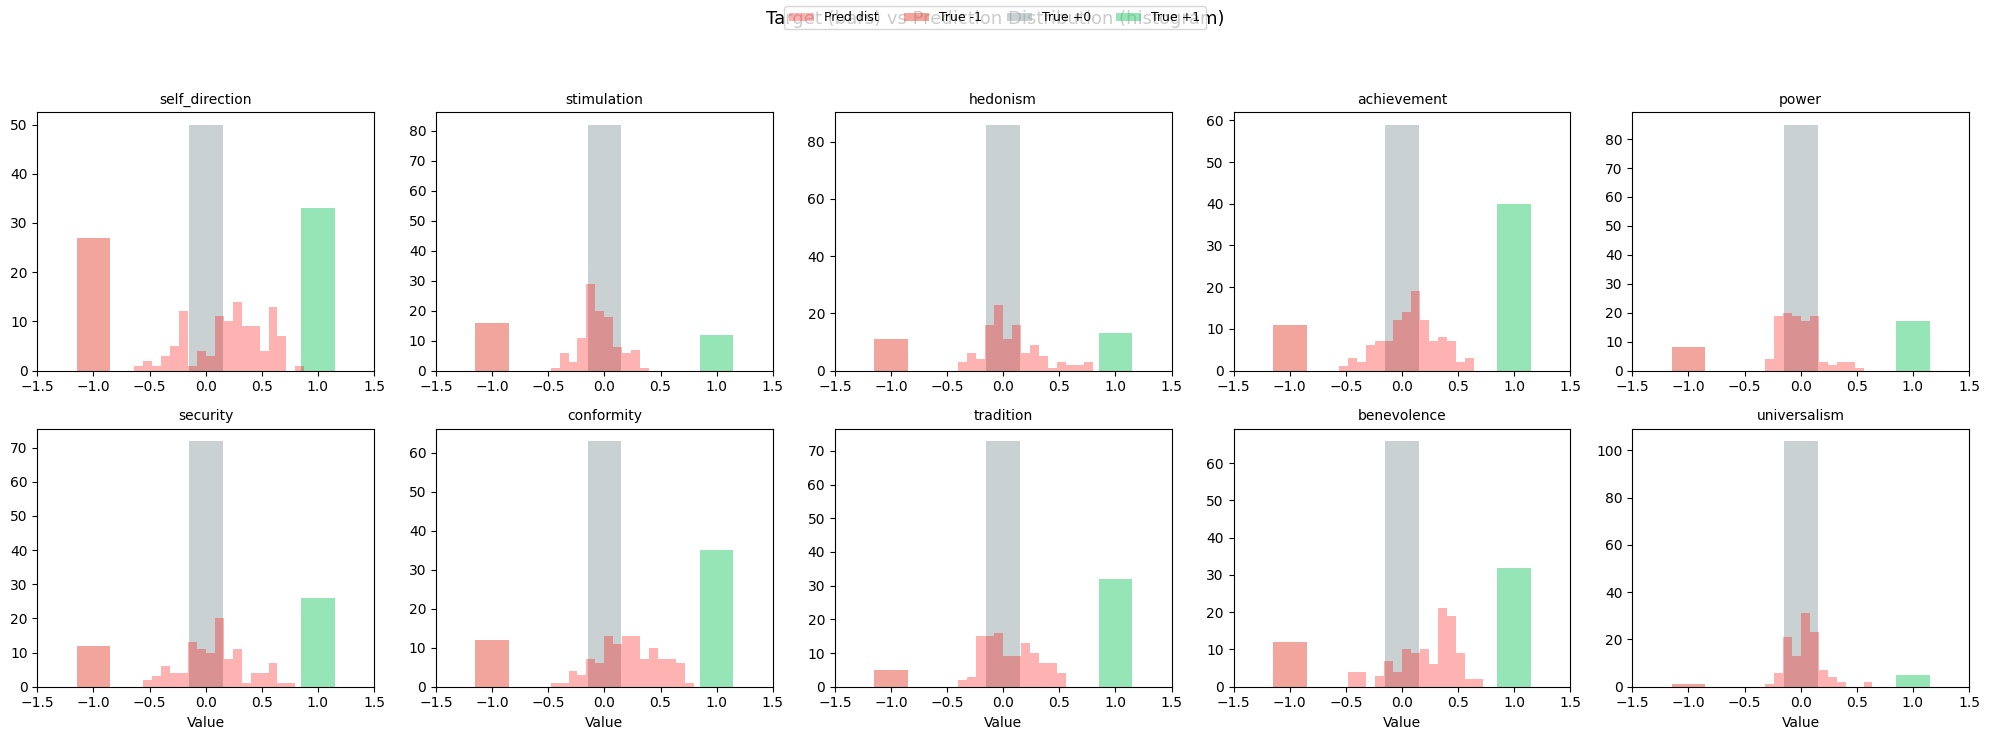


% predictions in [-0.3, 0.3] (hedging indicator):
  self_direction       52.7%
  stimulation          90.0% <- HEDGING
  hedonism             79.1%
  achievement          72.7%
  power                91.8% <- HEDGING
  security             71.8%
  conformity           60.0%
  tradition            79.1%
  benevolence          43.6%
  universalism         93.6% <- HEDGING
  MEAN                 73.5%


In [17]:
# Cell 4d — Prediction distribution overlay (2x5 grid)
fig, axes = plt.subplots(2, 5, figsize=(20, 7))
axes_flat = axes.flatten()

for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    ax = axes_flat[i]
    t = target_classes[:, i]
    # Target distribution (bars)
    for val, color in zip([-1, 0, 1], ["#e74c3c", "#95a5a6", "#2ecc71"]):
        count = (t == val).sum()
        ax.bar(
            val,
            count,
            width=0.3,
            color=color,
            alpha=0.5,
            label=f"True {val:+d}" if i == 0 else "",
        )
    # Prediction distribution (histogram)
    p = predictions[:, i]
    ax.hist(
        p,
        bins=30,
        range=(-1.2, 1.2),
        color="red",
        alpha=0.3,
        label="Pred dist" if i == 0 else "",
    )
    ax.set_title(dim, fontsize=10)
    ax.set_xlim(-1.5, 1.5)
    if i >= 5:
        ax.set_xlabel("Value")

handles, labels = axes_flat[0].get_legend_handles_labels()
if labels:
    fig.legend(handles, labels, loc="upper center", ncol=5, fontsize=9)
plt.suptitle(
    "Target (bars) vs Prediction Distribution (histogram)", fontsize=13, y=1.05
)
plt.tight_layout()
plt.show()

# Hedging diagnostic: % predictions in [-0.3, 0.3]
near_zero = ((predictions > -0.3) & (predictions < 0.3)).mean(axis=0)
print(f"\n% predictions in [-0.3, 0.3] (hedging indicator):")
for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    flag = " <- HEDGING" if near_zero[i] > 0.8 else ""
    print(f"  {dim:<20s} {near_zero[i]:.1%}{flag}")
print(f"  {'MEAN':<20s} {near_zero.mean():.1%}")

# Section 5: Calibration Analysis (Issue #9)

**Issue 9 — Uncertainty Calibration:** Does higher MC Dropout uncertainty correspond to higher actual error? If not, uncertainty estimates are unreliable.

In [18]:
# Cell 5a — Per-dimension error-uncertainty correlation
errors = np.abs(predictions - targets)

print(f"{'Dimension':<20s} {'Spearman(unc,err)':>18s} {'Status':>10s}")
print("-" * 52)
calibration_per_dim = {}
positive_count = 0
negative_count = 0

for i, dim in enumerate(SCHWARTZ_VALUE_ORDER):
    unc_dim = uncertainties[:, i]
    err_dim = errors[:, i]

    if np.std(unc_dim) < 1e-8 or np.std(err_dim) < 1e-8:
        corr = float("nan")
        status = "N/A"
    else:
        corr, _ = stats.spearmanr(unc_dim, err_dim)
        if corr > 0.1:
            status = "OK"
            positive_count += 1
        elif corr > 0:
            status = "WEAK"
            positive_count += 1
        else:
            status = "INVERSE"
            negative_count += 1

    calibration_per_dim[dim] = corr
    corr_str = f"{corr:.3f}" if not np.isnan(corr) else "N/A"
    print(f"{dim:<20s} {corr_str:>18s} {status:>10s}")

print(f"\nPositive calibration: {positive_count}/10 dimensions")
print(f"Negative calibration: {negative_count}/10 dimensions")

Dimension             Spearman(unc,err)     Status
----------------------------------------------------
self_direction                   -0.010    INVERSE
stimulation                      -0.188    INVERSE
hedonism                         -0.192    INVERSE
achievement                      -0.111    INVERSE
power                            -0.206    INVERSE
security                         -0.349    INVERSE
conformity                       -0.162    INVERSE
tradition                        -0.244    INVERSE
benevolence                      -0.310    INVERSE
universalism                     -0.338    INVERSE

Positive calibration: 0/10 dimensions
Negative calibration: 10/10 dimensions


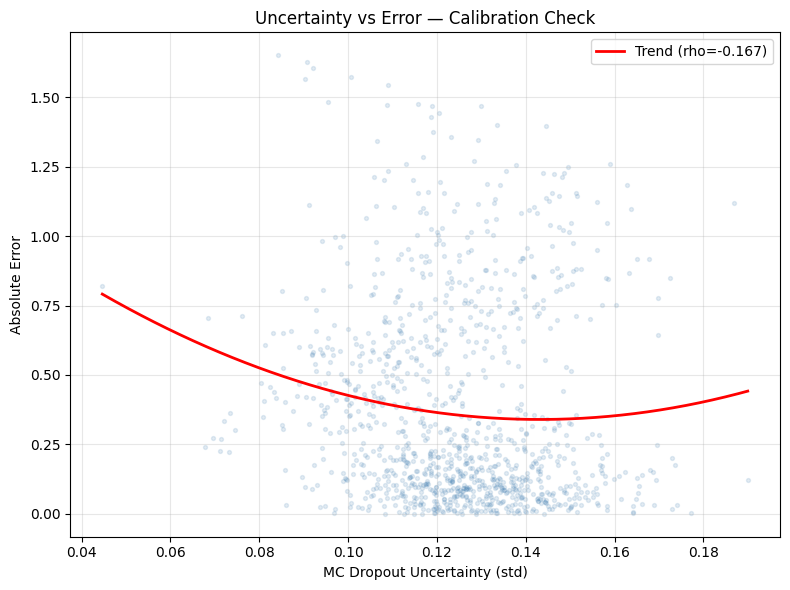

In [19]:
# Cell 5b — Calibration scatter plot
unc_flat = uncertainties.flatten()
err_flat = errors.flatten()
global_corr = results["calibration"]["error_uncertainty_correlation"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(unc_flat, err_flat, alpha=0.15, s=8, color="steelblue")

# Polynomial trend line (guard against NaN/Inf)
finite_mask = np.isfinite(unc_flat) & np.isfinite(err_flat)
if finite_mask.sum() > 3:
    z = np.polyfit(unc_flat[finite_mask], err_flat[finite_mask], 2)
    p = np.poly1d(z)
    x_line = np.linspace(unc_flat[finite_mask].min(), unc_flat[finite_mask].max(), 200)
    ax.plot(
        x_line, p(x_line), "r-", linewidth=2, label=f"Trend (rho={global_corr:.3f})"
    )
else:
    ax.text(
        0.5,
        0.5,
        "Insufficient finite data for trend",
        transform=ax.transAxes,
        ha="center",
    )

ax.set_xlabel("MC Dropout Uncertainty (std)")
ax.set_ylabel("Absolute Error")
ax.set_title("Uncertainty vs Error — Calibration Check")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Section 6: Issue Scorecard

Summary of all diagnostics for before/after comparison.

In [20]:
# Cell 6.1 — Scorecard
print("=" * 90)
print("DIAGNOSTIC SCORECARD")
print("=" * 90)

# Issue #9 — Calibration
print(f"\n{'--- #9 Calibration ':-<90s}")
corr = results["calibration"]["error_uncertainty_correlation"]
print(f"  Error-uncertainty correlation: {corr:.3f}")
print(f"  Positive dims: {positive_count}/10, Negative dims: {negative_count}/10")
print(f"  Guidance: >0.1 useful, <0 dangerous (uncertainty misleads)")

# Issue #10 — Imbalance
print(f"\n{'--- #10 Imbalance ':-<90s}")
print(f"  Overall neutral %: {neutral_pct:.1f}%")
print(
    f"  Flagged dims (>10x imbalance): {sum(1 for r in imbalance_ratios if r > 10)}/10"
)
print(f"  Unlearnable dims: {unlearnable if unlearnable else 'None'}")
minority_recalls = []
for dim in SCHWARTZ_VALUE_ORDER:
    recalls = recall_data[dim]
    non_neutral = [r for r in [recalls[0], recalls[2]] if not np.isnan(r)]
    if non_neutral:
        minority_recalls.extend(non_neutral)
mean_minority_recall = np.mean(minority_recalls) if minority_recalls else float("nan")
print(f"  Mean minority recall (-1, +1): {mean_minority_recall:.1%}")
print(f"  Guidance: Minority recall near 0% = model ignores rare classes")

# Issue #11 — Ordinal
print(f"\n{'--- #11 Ordinal ':-<90s}")
qwk_mean = results.get("qwk_mean", float("nan"))
print(f"  Mean QWK: {qwk_mean:.3f}")
hedging_pct = near_zero.mean() * 100
print(f"  Mean % predictions in [-0.3, 0.3]: {hedging_pct:.1f}%")
print(f"  Loss function used: {CONFIG['loss_fn']}")
print(f"  Guidance: High clustering = MSE hedging; QWK near 0 = chance")

# Issue #12 — Overfitting
print(f"\n{'--- #12 Overfitting ':-<90s}")
print(f"  Param/sample ratio: {param_sample_ratio:.1f}x")
print(f"  Gap at best epoch: {gap_at_best:+.4f}")
print(f"  Best epoch: {best_epoch + 1}/{len(history['train_loss'])}")
print(f"  Guidance: Ratio >10x high risk; gap >0.05 suggests overfitting")

# Issue #14 — Embedding
print(f"\n{'--- #14 Embedding ':-<90s}")
print(f"  Encoder: {CONFIG['encoder_model']}")
print(f"  Discrimination gap: {discrimination_gap:.3f}")
print(f"  Truncated entries: {pct_truncated:.1f}%")
print(
    f"  Guidance: Gap <0.1 = poor discrimination; >5% truncation = losing information"
)

print(f"\n{'=' * 90}")

DIAGNOSTIC SCORECARD

--- #9 Calibration -----------------------------------------------------------------------
  Error-uncertainty correlation: -0.167
  Positive dims: 0/10, Negative dims: 10/10
  Guidance: >0.1 useful, <0 dangerous (uncertainty misleads)

--- #10 Imbalance ------------------------------------------------------------------------
  Overall neutral %: 68.5%
  Flagged dims (>10x imbalance): 3/10
  Unlearnable dims: ['universalism']
  Mean minority recall (-1, +1): 12.5%
  Guidance: Minority recall near 0% = model ignores rare classes

--- #11 Ordinal --------------------------------------------------------------------------
  Mean QWK: 0.239
  Mean % predictions in [-0.3, 0.3]: 73.5%
  Loss function used: mse
  Guidance: High clustering = MSE hedging; QWK near 0 = chance

--- #12 Overfitting ----------------------------------------------------------------------
  Param/sample ratio: 731.6x
  Gap at best epoch: +0.0314
  Best epoch: 2/22
  Guidance: Ratio >10x high risk;